# **LAB 8 - DEVELOPING A RANDOM FOREST**
A Random Forest is a collection of **Decision Trees** (Just like a forest). The final output of the random forest is basically based on the output of its consisting decision trees.

# **Hence, First Develop a Decision Tree**

Consider the **dataset** given on the classroom as attached with this file.


---


# **Dataset description**

**TASK --->  Predict whether the income of the person is >50K OR <=50K.**

**age**: continuous.

**workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.

**fnlwgt**: continuous.

**education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.

**education-num**: continuous.

**marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.

**occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.

**relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.

**race**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.

**sex**: Female, Male.

**capital-gain**: continuous.

**capital-loss**: continuous.

**hours-per-week**: continuous.

**native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.


#SUBMISSION INSTRUCTIONS


*   SUBMIT THE FILES **entryno.ipynb** (CODE) and **entryno.pdf** (REPORT)
*   And A zip File **entryno.zip** which consists of the latex files; such that compiling the content of this zip should lead to the same report pdf as in the above point.



#**Q0: DO THE NECESSARY EDA FIRST**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from math import log2
import math

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import graphviz
from sklearn.tree import export_graphviz

from IPython.display import display


In [2]:
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]
train = pd.read_csv("/content/adulttrain.csv",  header=None, names=column_names)
test = pd.read_csv("/content/adulttest.csv",  header=None, names=column_names)


print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (32561, 15)
Test shape: (16281, 15)


In [3]:

print("\nTraining Data Sample:")
print(train.head())

print("\nTrain Data Info:")
train.info()
print("\nTrain Data Description (continuous features):")
print(train.describe())


Training Data Sample:
   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  income  
0          2174             0              40

In [4]:

print("\nTest Data Sample:")
print(test.head())


Test Data Sample:
   age   workclass  fnlwgt      education  education-num       marital-status  \
0   25     Private  226802           11th              7        Never-married   
1   38     Private   89814        HS-grad              9   Married-civ-spouse   
2   28   Local-gov  336951     Assoc-acdm             12   Married-civ-spouse   
3   44     Private  160323   Some-college             10   Married-civ-spouse   
4   18           ?  103497   Some-college             10        Never-married   

           occupation relationship    race      sex  capital-gain  \
0   Machine-op-inspct    Own-child   Black     Male             0   
1     Farming-fishing      Husband   White     Male             0   
2     Protective-serv      Husband   White     Male             0   
3   Machine-op-inspct      Husband   Black     Male          7688   
4                   ?    Own-child   White   Female             0   

   capital-loss  hours-per-week  native-country   income  
0             0     

In [5]:

categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    missing_count = (train[col] == '?').sum()
    print(f"Missing values in {col}: {missing_count}")

train.replace('?', np.nan, inplace=True)
test.replace('?', np.nan, inplace=True)




Missing values in workclass: 0
Missing values in education: 0
Missing values in marital-status: 0
Missing values in occupation: 0
Missing values in relationship: 0
Missing values in race: 0
Missing values in sex: 0
Missing values in native-country: 0
Missing values in income: 0


<ipython-input-6-6ddb6353df97>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='income', data=train, palette='pastel')


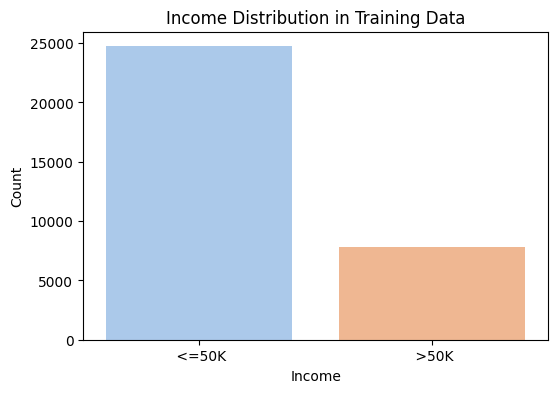

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x='income', data=train, palette='pastel')
plt.title("Income Distribution in Training Data")
plt.xlabel("Income")
plt.ylabel("Count")
plt.show()


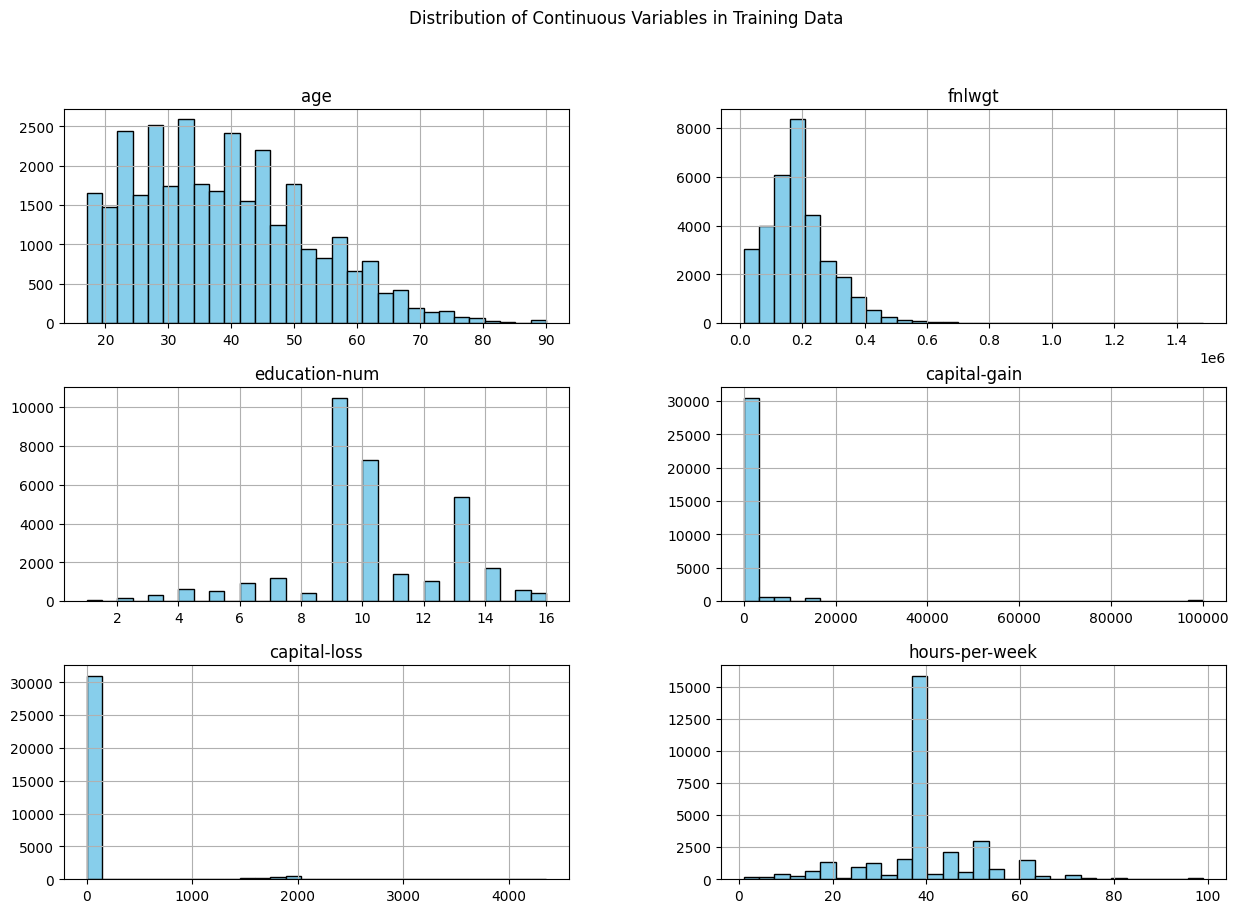

In [7]:
continuous_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
train[continuous_cols].hist(bins=30, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle("Distribution of Continuous Variables in Training Data")
plt.show()

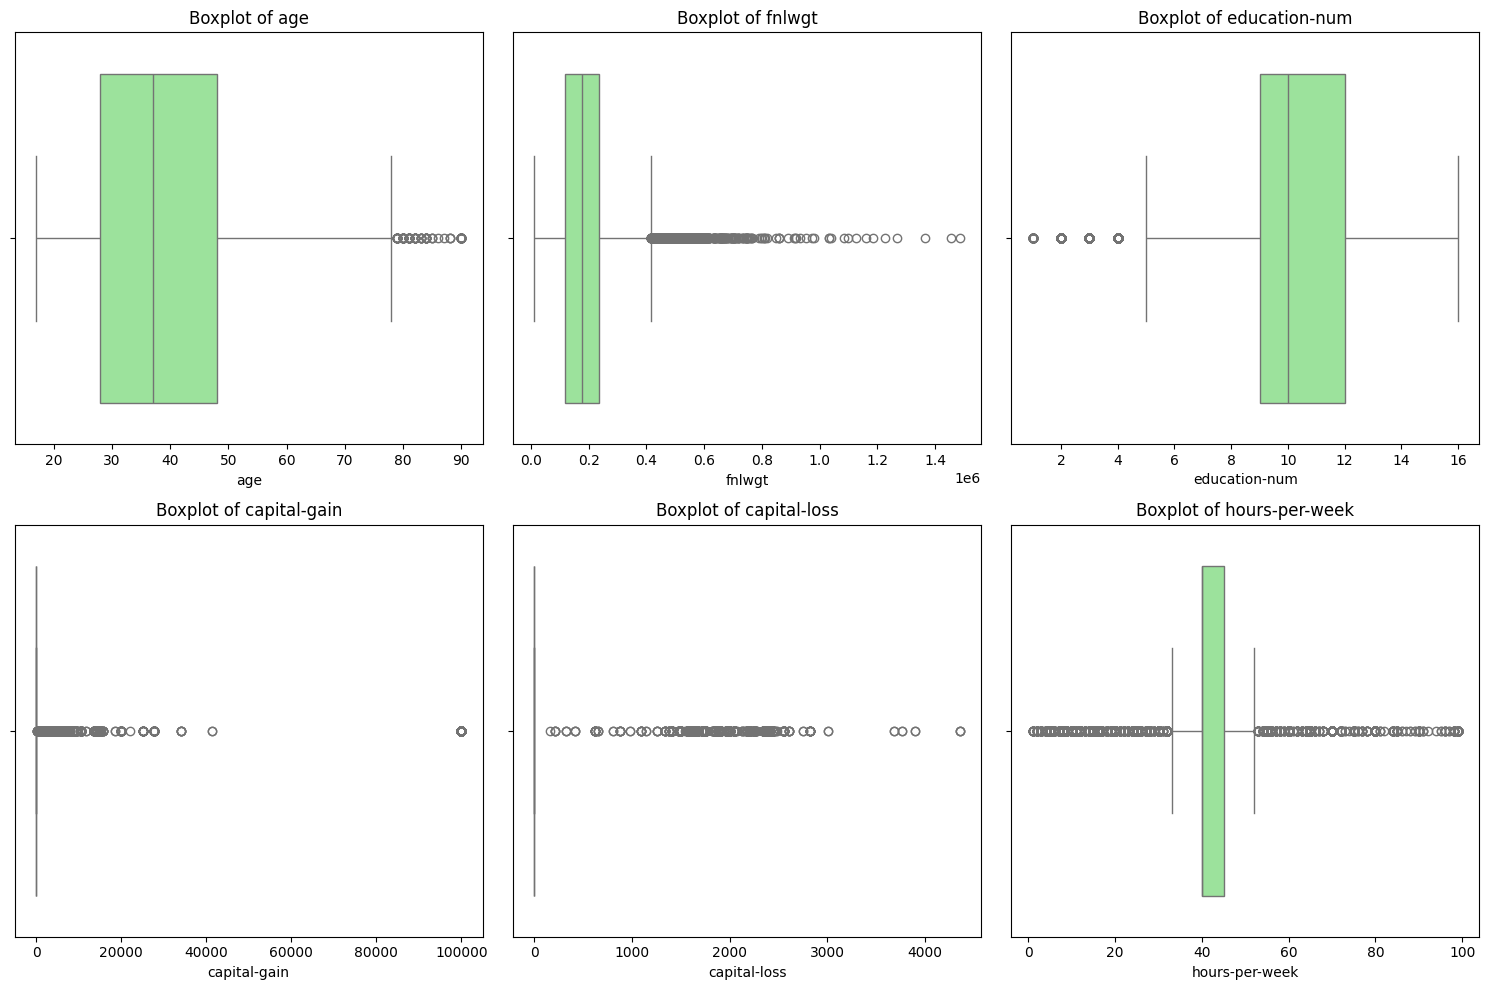

In [8]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=train[col], color='lightgreen')
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()


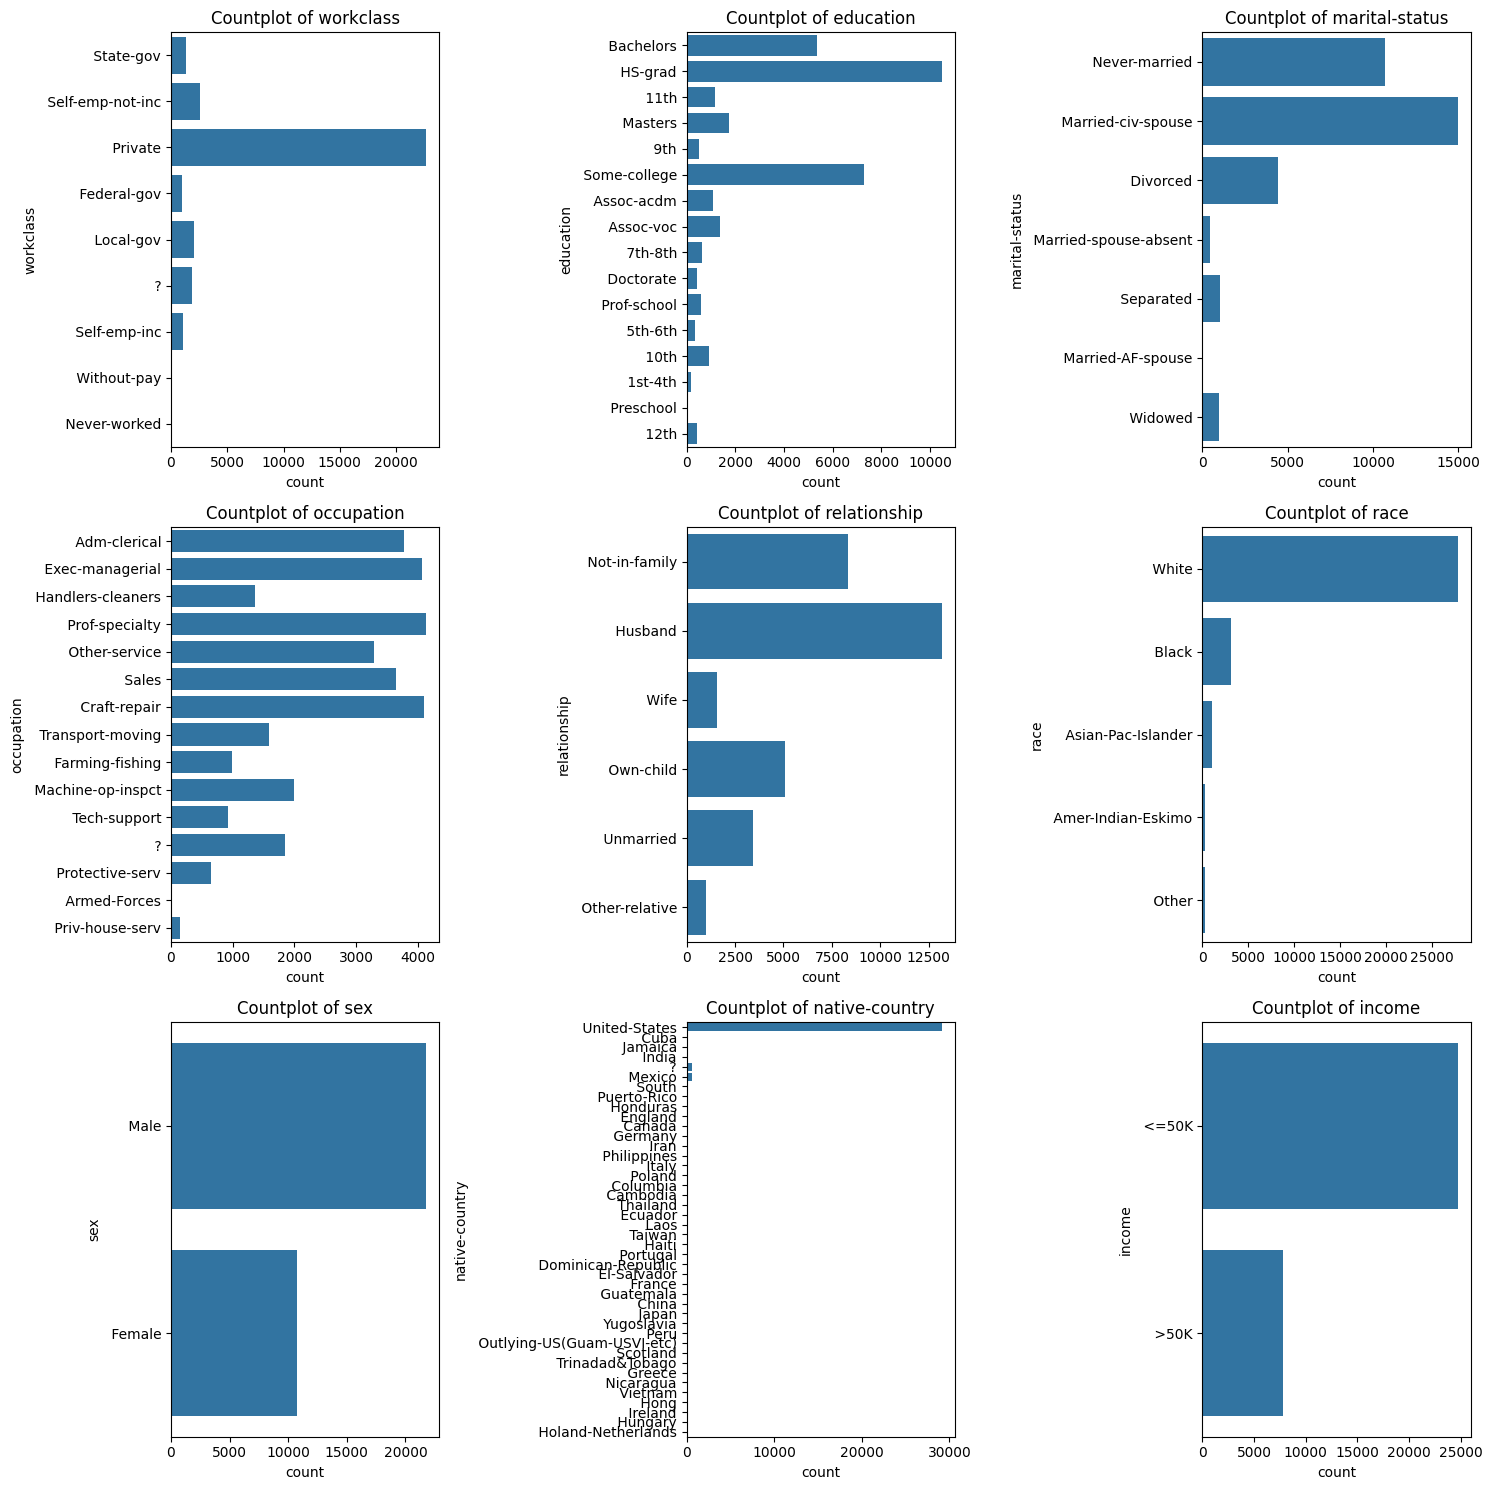

In [9]:

num_cols = 3
num_rows = math.ceil(len(categorical_cols) / num_cols)

plt.figure(figsize=(15, 15))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.countplot(y=col, data=train)
    plt.title(f"Countplot of {col}")

plt.tight_layout()
plt.show()

#**Q1: Implement a decision tree for the above classification problem**
*   The node splitting criteria should be based on **Information Gain** as discussed in the class.
*   The implementation should have the provision for both **Depth Selection** of the tree and **Pruning** at the nodes.
*   Train multiple trees with different depth values (atleast 8 values) and pruning ratios (atleast 2 ratios).
*   There will be atleast 16 trees (More the better, but < 30). Test all of them on the given testing set.
*   The report should have the classification metrics for all the trees in a **presentable and clear** way.
*   Hint : Use Recursive Functions.

In [10]:
def entropy(y):
    counts = np.bincount(y)
    probabilities = counts[np.nonzero(counts)] / len(y)
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))

def information_gain(y, left_y, right_y):
    parent_entropy = entropy(y)
    n = len(y)
    n_left = len(left_y)
    n_right = len(right_y)
    if n_left == 0 or n_right == 0:
        return 0
    child_entropy = (n_left / n) * entropy(left_y) + (n_right / n) * entropy(right_y)
    return parent_entropy - child_entropy

def best_split(X, y):
    best_gain = 0
    best_feature = None
    best_threshold = None
    n_features = X.shape[1]

    for feature in range(n_features):
        values = X[:, feature]
        thresholds = np.unique(values)

        for threshold in thresholds:
            left_idx = values <= threshold
            right_idx = values > threshold

            if np.sum(left_idx) == 0 or np.sum(right_idx) == 0:
                continue

            gain = information_gain(y, y[left_idx], y[right_idx])
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_threshold = threshold

    return best_feature, best_threshold, best_gain

In [11]:
from collections import Counter

class Node:
    def __init__(self, is_leaf=False, prediction=None, feature=None, threshold=None, left=None, right=None):
        self.is_leaf = is_leaf
        self.prediction = prediction
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right

class DecisionTree:
    def __init__(self, max_depth=5, pruning_threshold=0.01):
        self.max_depth = max_depth if max_depth is not None else float('inf')  # Set a default depth if None
        self.pruning_threshold = pruning_threshold
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        if len(np.unique(y)) == 1:
            return Node(is_leaf=True, prediction=y[0])

        if self.max_depth is not None and depth >= self.max_depth:
            return Node(is_leaf=True, prediction=Counter(y).most_common(1)[0][0])

        feature, threshold, gain = best_split(X, y)

        if feature is None or gain < self.pruning_threshold:
            return Node(is_leaf=True, prediction=Counter(y).most_common(1)[0][0])

        left_idx = X[:, feature] <= threshold
        right_idx = X[:, feature] > threshold

        if np.sum(left_idx) == 0 or np.sum(right_idx) == 0:
            return Node(is_leaf=True, prediction=Counter(y).most_common(1)[0][0])

        left_subtree = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right_subtree = self._build_tree(X[right_idx], y[right_idx], depth + 1)

        return Node(is_leaf=False, feature=feature, threshold=threshold, left=left_subtree, right=right_subtree)

    def _predict_sample(self, x, node):
        while not node.is_leaf:
            node = node.left if x[node.feature] <= node.threshold else node.right
        return node.prediction

    def predict(self, X):
        return np.array([self._predict_sample(x, self.root) for x in X])

In [12]:
train_df = train.copy()
test_df = test.copy()

train_df['income'] = train_df['income'].str.strip().str.replace('.', '', regex=False)
test_df['income'] = test_df['income'].str.strip().str.replace('.', '', regex=False)

le_income = LabelEncoder()
train_df['income'] = le_income.fit_transform(train_df['income'])
test_df['income'] = le_income.transform(test_df['income'])

categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

le = LabelEncoder()
for col in categorical_cols:
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

X_train, y_train = train_df.drop("income", axis=1), train_df["income"]
X_test, y_test = test_df.drop("income", axis=1), test_df["income"]


Without Recursion

    Depth  CCP Alpha  Accuracy  Precision (>50K)  Recall (>50K)  \
0     3.0       0.01  0.839199          0.760611       0.465939   
1     3.0       0.02  0.839199          0.760611       0.465939   
2     3.0       0.00  0.839199          0.760611       0.465939   
3     5.0       0.01  0.847245          0.769750       0.504160   
4     5.0       0.02  0.847245          0.769750       0.504160   
5     5.0       0.00  0.847245          0.769750       0.504160   
6     7.0       0.01  0.854616          0.792639       0.520801   
7     7.0       0.02  0.852159          0.780288       0.520801   
8     7.0       0.00  0.854616          0.792639       0.520801   
9     9.0       0.01  0.854677          0.772459       0.545502   
10    9.0       0.02  0.851668          0.761609       0.541602   
11    9.0       0.00  0.854309          0.770558       0.545762   
12   11.0       0.01  0.854984          0.715280       0.641446   
13   11.0       0.02  0.851115          0.755755       0.54628

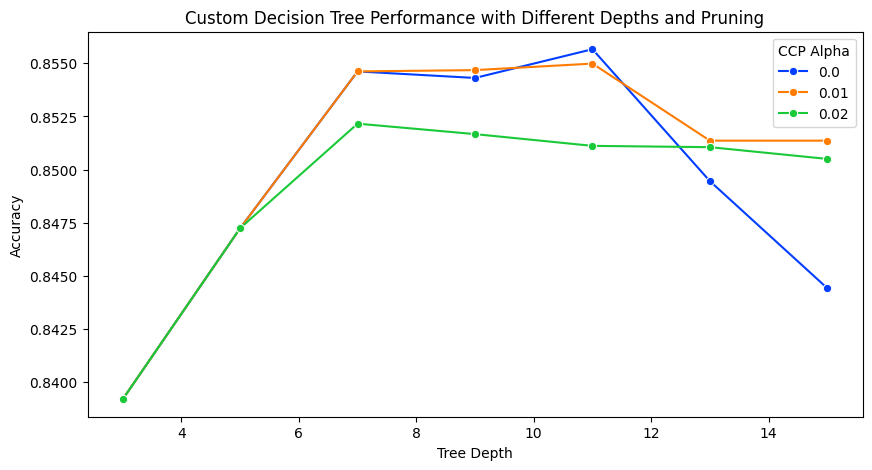

In [13]:
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()


depths = [3, 5, 7, 9, 11, 13, 15, None]
ccp_alphas = [0.01,0.02,0.0]

results = []

for depth in depths:
    for alpha in ccp_alphas:
        clf = DecisionTree(max_depth=depth, pruning_threshold=alpha)
        clf.fit(X_train_np, y_train_np)

        y_pred = clf.predict(X_test_np)

        acc = accuracy_score(y_test_np, y_pred)
        report = classification_report(y_test_np, y_pred, output_dict=True)
        cm = confusion_matrix(y_test_np, y_pred)

        results.append({
            'Depth': depth,
            'CCP Alpha': alpha,
            'Accuracy': acc,
            'Precision (>50K)': report['1']['precision'] if '1' in report else 0,
            'Recall (>50K)': report['1']['recall'] if '1' in report else 0,
            'F1-Score (>50K)': report['1']['f1-score'] if '1' in report else 0,
            'Confusion Matrix': cm
        })

results_df = pd.DataFrame(results)

print(results_df[['Depth', 'CCP Alpha', 'Accuracy', 'Precision (>50K)', 'Recall (>50K)', 'F1-Score (>50K)']])

plt.figure(figsize=(10, 5))
sns.lineplot(data=results_df, x='Depth', y='Accuracy', hue='CCP Alpha', marker='o', palette='bright')
plt.title("Custom Decision Tree Performance with Different Depths and Pruning")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.legend(title="CCP Alpha")
plt.show()

# **Q2: NOW MAKE A RANDOM FOREST**

This Forest should have a minimum of 11 trees (Keep it odd) of your choice of hyperparameters (depth, pruning, node splitting criteria)

Check the performance metric of the Random Forest **Versus** the best decision tree from the above question.

In [15]:
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report
from copy import deepcopy

class RandomForest:
    def __init__(self, n_trees=11, max_depth=5, pruning_threshold=0.01, max_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.pruning_threshold = pruning_threshold
        self.max_features = max_features  # Can be None, 'sqrt', or an int
        self.trees = []

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def _sample_features(self, X):
        n_features = X.shape[1]
        if self.max_features == 'sqrt':
            max_feats = int(np.sqrt(n_features))
        elif isinstance(self.max_features, int):
            max_feats = self.max_features
        else:
            max_feats = n_features
        feature_indices = np.random.choice(n_features, max_feats, replace=False)
        return feature_indices

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            X_sample, y_sample = self._bootstrap_sample(X, y)
            feature_indices = self._sample_features(X_sample)

            tree = DecisionTree(max_depth=self.max_depth, pruning_threshold=self.pruning_threshold)
            tree.feature_indices = feature_indices
            tree.fit(X_sample[:, feature_indices], y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = []
        for tree in self.trees:
            preds = tree.predict(X[:, tree.feature_indices])
            tree_preds.append(preds)
        tree_preds = np.array(tree_preds).T
        final_preds = [Counter(row).most_common(1)[0][0] for row in tree_preds]
        return np.array(final_preds)


In [16]:

X_train_np = X_train.values
y_train_np = y_train.values
X_test_np = X_test.values
y_test_np = y_test.values

forest = RandomForest(n_trees=11, max_depth=5, pruning_threshold=0.01, max_features='sqrt')
forest.fit(X_train_np, y_train_np)
forest_preds = forest.predict(X_test_np)

forest_accuracy = accuracy_score(y_test_np, forest_preds)
forest_report = classification_report(y_test_np, forest_preds, output_dict=True)

print(f"Random Forest Accuracy: {forest_accuracy:.4f}")
print(f"Precision (>50K): {forest_report['1']['precision']:.4f}")
print(f"Recall (>50K): {forest_report['1']['recall']:.4f}")
print(f"F1-Score (>50K): {forest_report['1']['f1-score']:.4f}")


Random Forest Accuracy: 0.7801
Precision (>50K): 0.9963
Recall (>50K): 0.0692
F1-Score (>50K): 0.1293


In [17]:
n_trees_options = [5,10, 15,20, 25 ]
depth_options = [3, 5, 7,10,15]
pruning_options = [0.0, 0.01, 0.05]


In [18]:
forest_results = []

for n_trees in n_trees_options:
    for depth in depth_options:
        for prune in pruning_options:
            forest = RandomForest(n_trees==n_trees, max_depth=depth, pruning_threshold=prune, max_features='sqrt')
            forest.fit(X_train_np, y_train_np)
            preds = forest.predict(X_test_np)

            acc = accuracy_score(y_test_np, preds)
            report = classification_report(y_test_np, preds, output_dict=True)
            precision = report["1"]["precision"]
            recall = report["1"]["recall"]
            f1 = report["1"]["f1-score"]

            forest_results.append({
                "n_trees": n_trees,
                "max_depth": depth,
                "pruning_threshold": prune,
                "accuracy": acc,
                "precision": precision,
                "recall": recall,
                "f1_score": f1
            })

forest_df = pd.DataFrame(forest_results)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

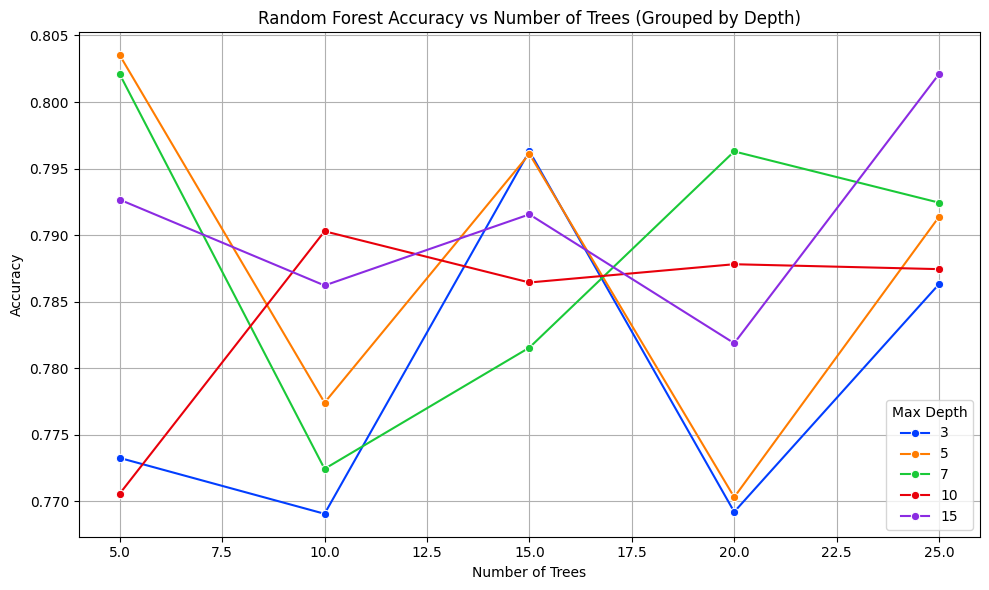

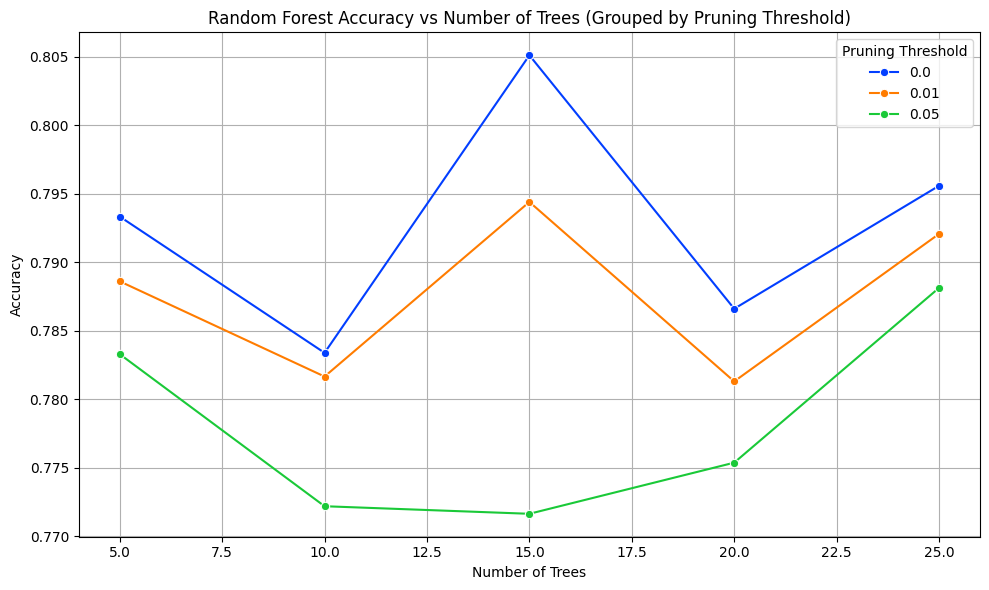

In [19]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=forest_df,
    x="n_trees",
    y="accuracy",
    hue="max_depth",
    palette="bright",
    marker="o",
    err_style=None
)
plt.title("Random Forest Accuracy vs Number of Trees (Grouped by Depth)")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(title="Max Depth")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=forest_df,
    x="n_trees",
    y="accuracy",
    hue="pruning_threshold",
    palette="bright",
    marker="o",
    err_style=None
)
plt.title("Random Forest Accuracy vs Number of Trees (Grouped by Pruning Threshold)")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(title="Pruning Threshold")
plt.tight_layout()
plt.show()


In [20]:
best_tree_result = max(results, key=lambda x: x["Accuracy"])
print("\nBest Decision Tree:")
print(best_tree_result)

print("\nComparison:")
print(f"Best Decision Tree Accuracy: {best_tree_result['Accuracy']:.4f}")
print(f"Random Forest Accuracy:     {forest_accuracy:.4f}")



Best Decision Tree:
{'Depth': 11, 'CCP Alpha': 0.0, 'Accuracy': 0.8556599717462072, 'Precision (>50K)': 0.7600834492350487, 'Recall (>50K)': 0.5683827353094124, 'F1-Score (>50K)': 0.6504016661707825, 'Confusion Matrix': array([[11745,   690],
       [ 1660,  2186]])}

Comparison:
Best Decision Tree Accuracy: 0.8557
Random Forest Accuracy:     0.7801


#**Q3: Compare the Performance of your Implemented version of RANDOM FOREST with the INBUILT RANDOM FOREST CLASSIFIER and the INBUILT LOGISTIC REGRESSION MODEL**

But this time, for this question only, you can use the inbuilt classifiers for comparison purpose.

In [21]:
from sklearn.ensemble import RandomForestClassifier

sk_rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
sk_rf.fit(X_train, y_train)
sk_rf_preds = sk_rf.predict(X_test)

sk_rf_accuracy = accuracy_score(y_test, sk_rf_preds)
sk_rf_f1 = f1_score(y_test, sk_rf_preds)


In [25]:
print(classification_report(y_test, sk_rf_preds, output_dict=True))

{'0': {'precision': 0.8581352048123747, 'recall': 0.9636509851226377, 'f1-score': 0.9078374180840183, 'support': 12435.0}, '1': {'precision': 0.8049201553733276, 'recall': 0.48491939677587104, 'f1-score': 0.6052247282167775, 'support': 3846.0}, 'accuracy': 0.8505620047908605, 'macro avg': {'precision': 0.8315276800928512, 'recall': 0.7242851909492544, 'f1-score': 0.7565310731503979, 'support': 16281.0}, 'weighted avg': {'precision': 0.8455644118547815, 'recall': 0.8505620047908605, 'f1-score': 0.8363523492780846, 'support': 16281.0}}


In [22]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

lr_accuracy = accuracy_score(y_test, lr_preds)
lr_f1 = f1_score(y_test, lr_preds)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
print(classification_report(y_test, lr_preds, output_dict=True))

{'0': {'precision': 0.8277400169923534, 'recall': 0.9401688781664657, 'f1-score': 0.8803795323619112, 'support': 12435.0}, '1': {'precision': 0.655076495132128, 'recall': 0.3673946957878315, 'f1-score': 0.4707646176911544, 'support': 3846.0}, 'accuracy': 0.8048645660585959, 'macro avg': {'precision': 0.7414082560622407, 'recall': 0.6537817869771486, 'f1-score': 0.6755720750265328, 'support': 16281.0}, 'weighted avg': {'precision': 0.7869523562175591, 'recall': 0.8048645660585959, 'f1-score': 0.78361772646401, 'support': 16281.0}}


In [23]:
forest = RandomForest(n_trees=11, max_depth=5, pruning_threshold=0.01, max_features='sqrt')
forest.fit(X_train_np, y_train_np)
forest_preds = forest.predict(X_test_np)

forest_accuracy = accuracy_score(y_test_np, forest_preds)
forest_f1 = f1_score(y_test_np, forest_preds)


In [27]:
print(classification_report(y_test, forest_preds, output_dict=True))

{'0': {'precision': 0.8004282099526374, 'recall': 0.992119018898271, 'f1-score': 0.88602413099684, 'support': 12435.0}, '1': {'precision': 0.8870967741935484, 'recall': 0.2002080083203328, 'f1-score': 0.3266864658464149, 'support': 3846.0}, 'accuracy': 0.8050488299244518, 'macro avg': {'precision': 0.8437624920730928, 'recall': 0.596163513609302, 'f1-score': 0.6063552984216274, 'support': 16281.0}, 'weighted avg': {'precision': 0.820901602131898, 'recall': 0.8050488299244518, 'f1-score': 0.7538938773165664, 'support': 16281.0}}


In [24]:
comparison_df = pd.DataFrame({
    "Model": ["Custom Random Forest", "Sklearn Random Forest", "Logistic Regression"],
    "Accuracy": [forest_accuracy, sk_rf_accuracy, lr_accuracy],
    "F1-Score": [forest_f1, sk_rf_f1, lr_f1]
})

print(comparison_df)


                   Model  Accuracy  F1-Score
0   Custom Random Forest  0.805049  0.326686
1  Sklearn Random Forest  0.850562  0.605225
2    Logistic Regression  0.804865  0.470765


#**Note - Follow all the above instructions Carefully.**